# Trabajo de Mentoria - DiploDatos - Parte 3

# Grupo A
    
Integrantes: 
    <li> Pamela Pairo
    <li> Bruno Garcia
    <li> Nicolas Chiapello
    <li> Martin Peñas
        

In [34]:
import io
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns

In [35]:
#df2 = pd.read_csv('https://raw.githubusercontent.com/Nicoch590/DatosFinancieros/main/datos_financieros_reducidos.csv',index_col=[0])
df = pd.read_csv('financial_data.csv',index_col=[0])

In [36]:
df = df.rename_axis('Ticker').reset_index()

## Puntuacion Piotrosky
Piotrosky es un profesor de la Universidad de Stanford, que creo un parámtro para conocer el comportamiento de las empresas en la bolsa de valores. Le otorga una puntuación entre 0 y 9, y demostro que si se invierte de acuerdo a dicho indice en las empresas con mejor categorización se puede lograr un 13 % de rentabilidad. También es aplicable su utilización para operar a corto (esperando que la acción baje de precio) en las empresas que logren una baja puntuación. Los criterios que suman puntos, son los detallados a continuación:

Profitability Criteria

1. Net Income > 0 (+1)

2. ROA > 0 (+1)

3. CFO > 0 (+1)

4. CFO > Net Income (earnings quality) (+1)

Leverage, Liquidity, and Source of Funds Criteria

5. Long Term Debt Current Year < Long Term Debt Previous Year (decreasing leverage) (+1)

6. Current Ratio Current Year > Current Ratio Previous Year (increasing liquidity) (+1)

7. No new shares issued in the last year (shares dilution) (+1)

Operating Efficiency Criteria

8. Gross Margin CY > Gross Margin PY (+1)

9. Asset Turnover Ratio CY > Asset Turnover Ratio PY (+1)


## Definimos a continuacion la Funcion Piotrosky

In [51]:
def Piotro(df, ticker):
    a = df[df.Ticker.isin([ticker])].sort_values(by="year")
    
     #Net Income > 0 (+1)
    conditionlist1 = [
        (a['Net Income'] > 0 )]
        #(a['Net Income'] < 0 )]
    choicelist1 = [1]
    a['p1'] = np.select(conditionlist1, choicelist1, default=0)

    #ROA > 0 (+1)
    conditionlist2 = [
        (a['returnOnAssets'] >= 0), (a['returnOnAssets'] < 0)]
    choicelist2 = [1, 0]
    a['p2'] = np.select(conditionlist2, choicelist2, default='Not Specified')

    #CFO > 0 (+1)
    conditionlist3 = [
        (a['Operating Cash Flow'] >= 0), (a['Operating Cash Flow'] < 0)]
    choicelist3 = [1, 0]
    a['p3'] = np.select(conditionlist2, choicelist3, default='Not Specified')

    #CFO > Net Income (earnings quality) (+1)
    conditionlist4 = [
        (a['Operating Cash Flow'] >= a['Net Income'])]
    choicelist4 = [1]
    a['p4'] = np.select(conditionlist4, choicelist4, default=0)

    #Long Term Debt Current Year < Long Term Debt Previous Year (decreasing leverage) (+1)
    a['Long-term debt_shift'] =  a['Long-term debt'].shift()

    conditionlist5 = [
        (a['Long-term debt'] >= a['Long-term debt_shift']),(a['Long-term debt'] < a['Long-term debt_shift'])]
    choicelist5 = [0, 1]
    a['p5'] = np.select(conditionlist5, choicelist5, default='Not Specified')

    #Current Ratio Current Year > Current Ratio Previous Year (increasing liquidity) (+1)
    a['currentRatio_shift'] =  a['currentRatio'].shift()

    conditionlist6 = [
        (a['currentRatio'] >= a['currentRatio_shift']),(a['currentRatio'] < a['currentRatio_shift'])]
    choicelist6 = [1, 0]
    a['p6'] = np.select(conditionlist6, choicelist6, default='Not Specified')

    #No new shares issued in the last year (shares dilution) (+1)
    conditionlist7 = [
        (a['Issuance (buybacks) of shares'] >= 0),(a['Issuance (buybacks) of shares'] < 0)]
    choicelist7 = [0, 1]
    a['p7'] = np.select(conditionlist7, choicelist7, default='Not Specified')

    #Gross Margin CY > Gross Margin PY (+1)
    a['Gross Margin_shift'] =  a['Gross Margin'].shift()

    conditionlist8 = [
        (a['Gross Margin'] >= a['Gross Margin_shift']),(a['Gross Margin'] < a['Gross Margin_shift'])]
    choicelist8 = [1, 0]
    a['p8'] = np.select(conditionlist8, choicelist8, default='Not Specified')

    #Asset Turnover Ratio CY > Asset Turnover Ratio PY (+1)
    a['assetTurnover_shift'] =  a['assetTurnover'].shift()

    conditionlist9 = [
        (a['assetTurnover'] >= a['assetTurnover_shift']),(a['assetTurnover'] < a['assetTurnover_shift'])]
    choicelist9 = [1, 0]
    a['p9'] = np.select(conditionlist9, choicelist9, default='Not Specified')

    a['p1'] = pd.to_numeric(a['p1'], downcast="integer")
    a['p2'] = pd.to_numeric(a['p2'])
    a['p3'] = pd.to_numeric(a['p3'])
    a['p4'] = pd.to_numeric(a['p4'])
    a['p5'] = pd.to_numeric(a['p5'], downcast="integer", errors="coerce")
    a['p6'] = pd.to_numeric(a['p6'], downcast="integer", errors="coerce")
    a['p7'] = pd.to_numeric(a['p7'])
    a['p8'] = pd.to_numeric(a['p8'], downcast="integer", errors="coerce")
    a['p9'] = pd.to_numeric(a['p9'], downcast="integer", errors="coerce")

    a["Piotrosky"] = a.p1 + a.p2 + a.p3 + a.p4 + a.p5 + a.p6 + a.p7 + a.p8 + a.p9
    
    a.index = a["year"]
    
    a["Rendimiento>0"] = np.where(a["AnualPriceVariation"]>= 0, "si", "no")
    
    return a

### Vemos un ejemplo de los resultados que nos arroja la función Piotrosky

In [55]:
Piotro(df, "IBM")

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,priceBookValueRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,ebitperRevenue,ebtperEBIT,niperEBT,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,netProfitMargin,effectiveTaxRate,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,nIperEBT,eBTperEBIT,eBITperRevenue,payablesTurnover,inventoryTurnover,fixedAssetTurnover,assetTurnover,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,debtRatio,debtEquityRatio,longtermDebtToCapitalization,totalDebtToCapitalization,interestCoverage,cashFlowToDebtRatio,companyEquityMultiplier,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,payoutRatio,operatingCashFlowSalesRatio,freeCashFlowOperatingCashFlowRatio,cashFlowCoverageRatios,shortTermCoverageRatios,capitalExpenditureCoverageRatios,dividendpaidAndCapexCoverageRatios,dividendPayoutRatio,Revenue per Share,Net Income per Share,Operating Cash Flow per Share,Free Cash Flow per Share,Cash per Share,Book Value per Share,Tangible Book Value per Share,Shareholders Equity per Share,Interest Debt per Share,Market Cap,Enterprise Value,PE ratio,Price to Sales Ratio,POCF ratio,PFCF ratio,PB ratio,PTB ratio,EV to Sales,Enterprise Value over EBITDA,EV to Operating cash flow,EV to Free cash flow,Earnings Yield,Free Cash Flow Yield,Debt to Equity,Debt to Assets,Net Debt to EBITDA,Current ratio,Interest Coverage,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Intangibles to Total Assets,Capex to Operating Cash Flow,Capex to Revenue,Capex to Depreciation,Stock-based compensation to Revenue,Graham Number,ROIC,Return on Tangible Assets,Graham Net-Net,Working Capital,Tangible Asset Value,Net Current Asset Value,Invested Capital,Average Receivables,Average Payables,Average Inventory,Days Sales Outstanding,Days Payables Outstanding,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share

### Observamos el comportamiento en diferentes Tickers / Activos
La función que definimos con anterioridad nos sirve para iterar sobre los tickers en los que queremos conocer el indice Piotrosky. A modo de ejemplo, vemos los resultados de las empresas Apple, IBM, Walmart y Boeing

In [56]:
tick = ["AAPL", "IBM", "WMT", "BA"]

In [57]:
b = pd.DataFrame()

for i in tick:
    b = b.append(Piotro(df, i))
    
#b

### Para poder compararlos, aqui conocemos el promedio de los años 2015, 2016, 2017 y 2018 del indice Piotrosky

In [58]:
mean = b.groupby(["Ticker"])["Piotrosky"].mean()
mean

Ticker
AAPL    6.50
BA      6.50
IBM     6.25
WMT     7.75
Name: Piotrosky, dtype: float64

### Aqui podemos ver las columnas sobre las que se basa el índice, y verlo de manera extendida

In [93]:
pd.set_option("max_columns", None)
DGnew = b[["Ticker", "Net Income", "returnOnAssets", "Operating Cash Flow", "Long-term debt", 
            "currentRatio", "Issuance (buybacks) of shares", "Gross Margin", "assetTurnover", "p1", "p2",
           "p3", "p4", "p5", "p6", "p7", "p8", "p9", "Piotrosky", "year", "AnualPriceVariation", "Rendimiento>0"]].copy()

#DGnew.to_excel("DGnew.xlsx", 'Hoja de datos')
DGnew

,Ticker,Net Income,returnOnAssets,Operating Cash Flow,Long-term debt,currentRatio,Issuance (buybacks) of shares,Gross Margin,assetTurnover,p1,p2,p3,p4,p5,p6,p7,p8,p9,Piotrosky,year,AnualPriceVariation,Rendimiento>0
year,,,,,,,,,,,,,,,,,,,,,,
2014,AAPL,3.951000e+10,1.5369,5.971300e+10,2.898700e+10,1.080,-4.427000e+10,0.3859,0.788457,1,1,1,1,NaN,NaN,1,NaN,NaN,NaN,2014,-2.082268,no
2015,AAPL,5.339400e+10,1.7092,8.126600e+10,5.332900e+10,1.109,-3.471000e+10,0.4006,0.804956,1,1,1,1,0.0,1.0,1,1.0,1.0,8.0,2015,12.384342,si
2016,AAPL,4.568700e+10,0.8326,6.623100e+10,7.542700e+10,1.353,-2.922700e+10,0.3908,0.670340,1,1,1,1,0.0,1.0,1,0.0,0.0,6.0,2016,48.042508,si
2017,AAPL,4.835100e+10,0.7847,6.422500e+10,9.720700e+10,1.276,-3.234500e+10,0.3847,0.610771,1,1,1,1,0.0,0.0,1,0.0,0.0,5.0,2017,-7.054338,no
2018,AAPL,5.953100e+10,1.0497,7.743400e+10,9.373500e+10,1.133,-7.206900e+10,0.3834,0.726215,1,1,1,1,1.0,0.0,1,0.0,1.0,7.0,2018,88.742465,si
2014,IBM,1.202200e+10,0.6475,1.686800e+10,3.499100e+10,1.197,-1.297000e+10,0.5001,0.791270,1,1,1,1,NaN,NaN,1,NaN,NaN,NaN,2014,-11.632237,no
2015,IBM,1.319000e+10,0.6956,1.725500e+10,3.342800e+10,1.240,-4.287000e+09,0.4977,0.739771,1,1,1,1,1.0,1.0,1,0.0,0.0,7.0,2015,27.965236,si
2016,IBM,1.187200e+10,0.6437,1.708400e+10,3.465500e+10,1.210,-3.502000e+09,0.4819,0.680335,1,1,1,1,0.0,0.0,1,0.0,0.0,5.0,2016,-4.676964,no
2017,IBM,5.753000e+09,0.2449,1.672400e+10,3.983700e+10,1.331,-4.340000e+09,0.4668,0.631314,1,1,1,1,0.0,1.0,1,0.0,0.0,6.0,2017,-22.974705,no


In [94]:
DGnew.groupby(by="Ticker")

## En el siguiente grafico podemos ver la relación entre el Indice Piotrosky y cómo se comporto el precio en el año siguiente:

<Figure size 1800x1080 with 0 Axes>

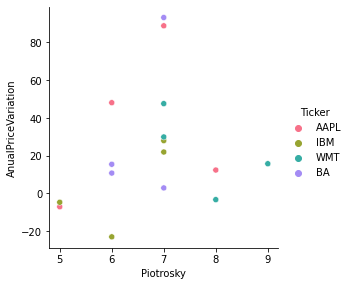

In [118]:
plt.figure(figsize = (25,15))
axis=sns.pairplot(data=DGnew,palette="husl",x_vars="Piotrosky", y_vars="AnualPriceVariation", hue="Ticker",height = 4, aspect = 1)